In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Load features
nifty = pd.read_csv("../data/nifty_features.csv", index_col=0, parse_dates=True)

nifty.head()


,price,log_return,volatility_20d,mean_return_20d,ma_50,price_ma_ratio
Date,,,,,,
2010-04-19,5203.649902,-0.011265,0.007627,-0.000271,5086.877012,1.022956
2010-04-20,5230.100098,0.005070,0.007695,-0.000151,5094.877012,1.026541
2010-04-21,5244.899902,0.002826,0.007686,-0.000170,5101.138008,1.028182
2010-04-22,5269.350098,0.004651,0.007313,0.000612,5109.618008,1.031261
2010-04-23,5304.100098,0.006573,0.007401,0.000748,5121.327012,1.035689


In [4]:
nifty.info()
nifty.isna().sum()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3855 entries, 2010-04-19 to 2025-12-23
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            3855 non-null   float64
 1   log_return       3855 non-null   float64
 2   volatility_20d   3855 non-null   float64
 3   mean_return_20d  3855 non-null   float64
 4   ma_50            3855 non-null   float64
 5   price_ma_ratio   3855 non-null   float64
dtypes: float64(6)
memory usage: 210.8 KB


price              0
log_return         0
volatility_20d     0
mean_return_20d    0
ma_50              0
price_ma_ratio     0
dtype: int64

Selecting features for Regime model

In [5]:
features = nifty[['mean_return_20d', 'volatility_20d', 'price_ma_ratio']]


Standardising features

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(features)

X.shape


(3855, 3)

# Training the HMM model

In [7]:
from hmmlearn.hmm import GaussianHMM


In [8]:
# Initialize HMM
hmm = GaussianHMM(
    n_components=3,        # number of regimes
    covariance_type="full",
    n_iter=1000,
    random_state=42
)

# Fit model
hmm.fit(X)


,n_components,3
,covariance_type,'full'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,42


In [9]:
# Predict hidden states
regimes = hmm.predict(X)

# Attach to dataframe
nifty['regime'] = regimes

nifty[['price', 'regime']].head()


,price,regime
Date,,
2010-04-19,5203.649902,2
2010-04-20,5230.100098,2
2010-04-21,5244.899902,2
2010-04-22,5269.350098,2
2010-04-23,5304.100098,2


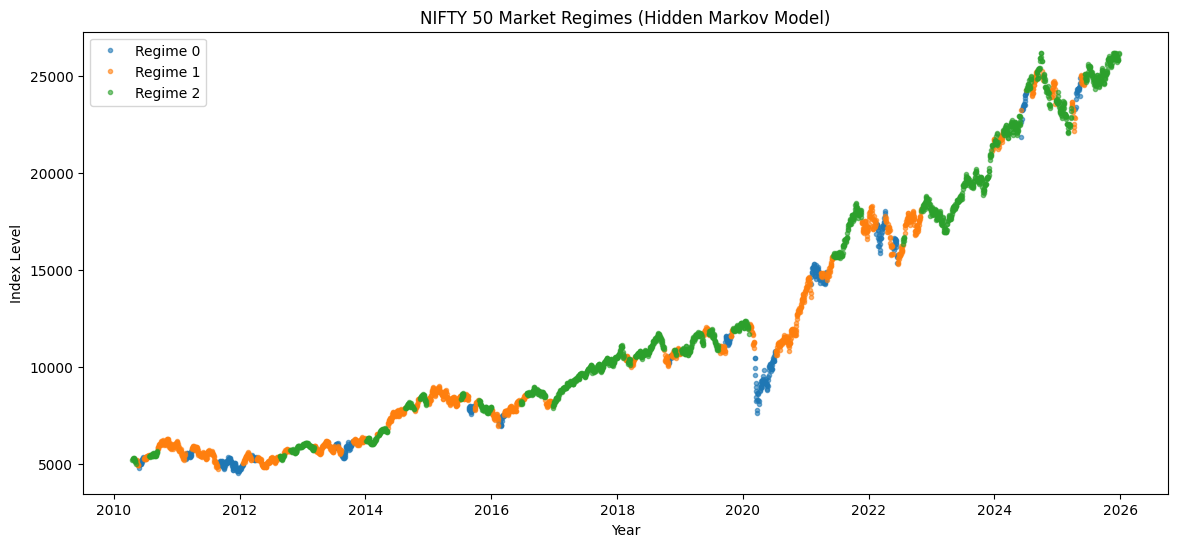

In [10]:
plt.figure(figsize=(14,6))

for regime in range(3):
    mask = nifty['regime'] == regime
    plt.plot(
        nifty.index[mask],
        nifty['price'][mask],
        '.',
        label=f"Regime {regime}",
        alpha=0.6
    )

plt.title("NIFTY 50 Market Regimes (Hidden Markov Model)")
plt.xlabel("Year")
plt.ylabel("Index Level")
plt.legend()
plt.show()


In [11]:
regime_stats = nifty.groupby('regime')[[
    'log_return',
    'volatility_20d',
    'mean_return_20d',
    'price_ma_ratio'
]].mean()

regime_stats


,log_return,volatility_20d,mean_return_20d,price_ma_ratio
regime,,,,
0,0.001091,0.017292,-0.000228,0.988371
1,0.000259,0.010001,0.000442,1.012110
2,0.000355,0.006346,0.000578,1.015998


In [12]:
regime_labels = {
    0: "Stress / Risk-Off",
    1: "Sideways / Neutral",
    2: "Bull / Risk-On"
}


In [14]:
nifty['regime_label'] = nifty['regime'].map(regime_labels)
nifty[['price', 'regime_label']].head()

,price,regime_label
Date,,
2010-04-19,5203.649902,Bull / Risk-On
2010-04-20,5230.100098,Bull / Risk-On
2010-04-21,5244.899902,Bull / Risk-On
2010-04-22,5269.350098,Bull / Risk-On
2010-04-23,5304.100098,Bull / Risk-On


# Baseline strategy

Baseline = Always Invested in NIFTY

Daily strategy return = market return

In [16]:
nifty['baseline_return'] = nifty['log_return']


Regime-Aware Strategy


In [17]:
nifty['regime_strategy_return'] = 0.0

mask_invest = nifty['regime_label'].isin(["Bull / Risk-On", "Sideways / Neutral"])
nifty.loc[mask_invest, 'regime_strategy_return'] = nifty.loc[mask_invest, 'log_return']


In [18]:
nifty['baseline_equity'] = (1 + nifty['baseline_return']).cumprod()
nifty['regime_equity'] = (1 + nifty['regime_strategy_return']).cumprod()


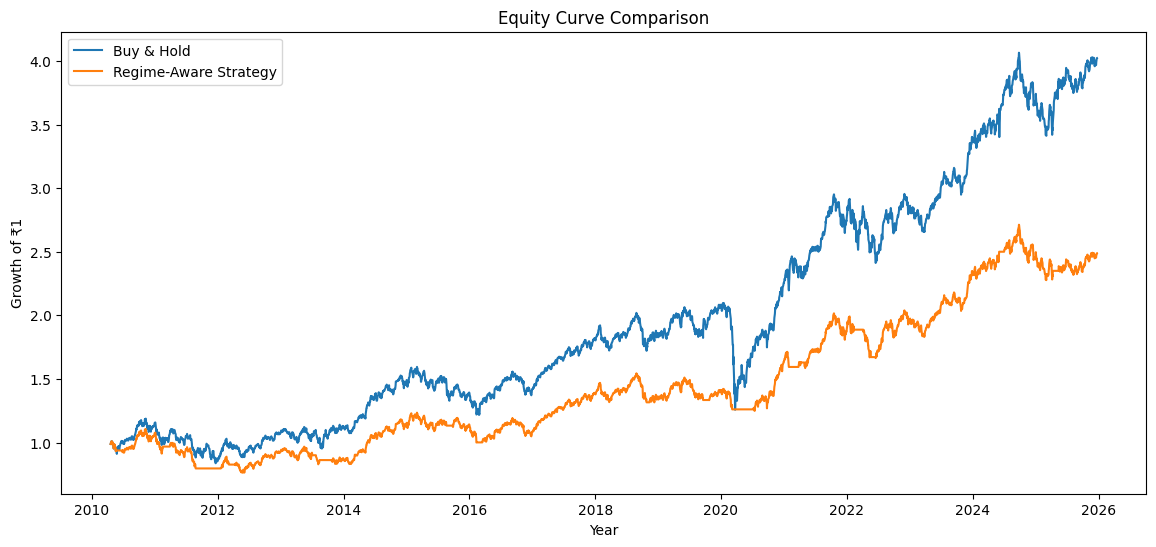

In [19]:
plt.figure(figsize=(14,6))
plt.plot(nifty.index, nifty['baseline_equity'], label='Buy & Hold')
plt.plot(nifty.index, nifty['regime_equity'], label='Regime-Aware Strategy')
plt.title("Equity Curve Comparison")
plt.xlabel("Year")
plt.ylabel("Growth of ₹1")
plt.legend()
plt.show()


In [20]:
import numpy as np

def sharpe_ratio(returns, risk_free_rate=0):
    return np.sqrt(252) * (returns.mean() - risk_free_rate) / returns.std()

def max_drawdown(equity_curve):
    peak = equity_curve.cummax()
    drawdown = (equity_curve - peak) / peak
    return drawdown.min()


Computing metrics

In [21]:
metrics = pd.DataFrame({
    "Strategy": ["Buy & Hold", "Regime-Aware"],
    "Sharpe": [
        sharpe_ratio(nifty['baseline_return']),
        sharpe_ratio(nifty['regime_strategy_return'])
    ],
    "Max Drawdown": [
        max_drawdown(nifty['baseline_equity']),
        max_drawdown(nifty['regime_equity'])
    ]
})

metrics


,Strategy,Sharpe,Max Drawdown
0,Buy & Hold,0.632011,-0.400372
1,Regime-Aware,0.536907,-0.310316


In [22]:
regime_performance = nifty.groupby('regime_label')['log_return'].agg([
    'mean', 'std', 'count'
])

regime_performance


,mean,std,count
regime_label,,,
Bull / Risk-On,0.000355,0.006684,1769
Sideways / Neutral,0.000259,0.010211,1562
Stress / Risk-Off,0.001091,0.018504,524


Stress → high std, weak returns

Bull → strong returns, low risk

In [23]:
print(nifty)

                   price  log_return  volatility_20d  mean_return_20d  \
Date                                                                    
2010-04-19   5203.649902   -0.011265        0.007627        -0.000271   
2010-04-20   5230.100098    0.005070        0.007695        -0.000151   
2010-04-21   5244.899902    0.002826        0.007686        -0.000170   
2010-04-22   5269.350098    0.004651        0.007313         0.000612   
2010-04-23   5304.100098    0.006573        0.007401         0.000748   
...                  ...         ...             ...              ...   
2025-12-17  25818.550781   -0.001608        0.005183        -0.000451   
2025-12-18  25815.550781   -0.000116        0.005003        -0.000724   
2025-12-19  25966.400391    0.005826        0.005113        -0.000196   
2025-12-22  26172.400391    0.007902        0.005326         0.000408   
2025-12-23  26177.150391    0.000181        0.005271         0.000562   

                   ma_50  price_ma_ratio  regime  

In [25]:
nifty.to_csv("C:/Users/Hemanshu/PycharmProjects/market_regime_detection/data/nifty_strategy.csv")
